In [1]:
import nyroglancer

In [1]:
from gala import evaluate as ev, imio, viz, morpho

In [2]:
from skimage.util import regular_seeds

In [5]:
import numpy as np

In [4]:
raw, gt = imio.read_cremi("Cremi_Data/sample_B_20160501.hdf", datasets=['volumes/raw', 'volumes/labels/neuron_ids'])

In [6]:
from matplotlib import pyplot as plt

In [7]:
import h5py

In [8]:
import ipyvolume as ipy

In [10]:
ab = nyroglancer.Viewer()

In [11]:
ab.add(raw[::4])

In [73]:
raw_small = raw[0:20, :, :]

In [13]:
raw_vtk = imio.write_vtk(raw_small.astype('uint8'), fn="spaced2_vtk_raw.vtk",  spacing=a[::-1])

NameError: name 'raw_small' is not defined

In [10]:
raw_ab = 255 - raw_small
raw_ab.dtype

dtype('uint8')

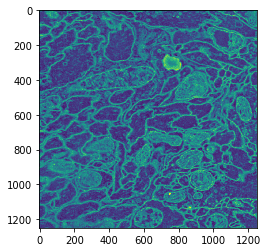

In [11]:
%matplotlib inline
plt.imshow(raw_ab[4])

In [67]:
import sysconfig

In [72]:
sysconfig.get_config_vars('PATH')

[None]

In [13]:
ab_seeds = regular_seeds(raw_ab.shape, n_points=1900)

In [14]:
raw_seg = morpho.watershed_sequence(raw_ab, ab_seeds, n_jobs=-1)

In [23]:
import multiprocessing

In [24]:
multiprocessing.cpu_count()

4

In [16]:
ipy.quickvolshow(volume0)

NameError: name 'volume0' is not defined

In [17]:
a = [40, 4, 4]

In [47]:
viz.draw_seg?

In [15]:
sparse_seg = imio.extract_segments(raw_seg, ids=np.arange(1, 50))

In [16]:
_, bins = np.histogram(sparse_seg, bins=255)
volume0 = np.clip(np.digitize(sparse_seg, bins), 0, 255).astype(np.uint8)

In [20]:
np.argsort(np.bincount(gt_raw.astype(int).ravel()))[-10:]
gt_raw = gt[0:20, :, :]
gt_small = imio.extract_segments(gt_raw, ids = [1871,  73394,  20423,   1811,   1860,  39717,   1852,  33161,
       105220,   1771])

array([  1871,  73394,  20423,   1811,   1860,  39717,   1852,  33161,
       105220,   1771])

In [39]:
imio.write_vtk(gt_small,fn ="gt_b.vtk", spacing=a[::-1])

In [118]:
imio.write_vtk(volume0, fn="new_seg_b_small.vtk", spacing = a[::-1])

In [21]:
from gala import classify, features, agglo

In [22]:
gt_tiny = gt[0:5, 0:30, 0:30]
raw_tiny= raw[0:5, 0:30, 0:30]
ws_seeds = regular_seeds(raw_tiny[0].shape, n_points=90)
ws_seeds = np.broadcast_to(ws_seeds, raw_tiny.shape)
ws_tiny = morpho.watershed_sequence(raw_tiny, ws_seeds, n_jobs=-1)

In [33]:
gt_larger = gt[0:8, 0:120, 0:120]
raw_larger = raw[0:8, 0:120, 0:120]
ws_larger_seeds = regular_seeds(raw_larger[0].shape, n_points=360)
ws_larger_seeds = np.broadcast_to(ws_larger_seeds, raw_larger.shape)
ws_larger = morpho.watershed_sequence(raw_larger, ws_larger_seeds, n_jobs=-1)

In [34]:
raw_testing = raw[0:5, 60:90, 60:90]
gt_testing = gt[0:5, 60:90, 60:90]
ws_testing = morpho.watershed_sequence(raw_testing, ws_seeds, n_jobs=-1)

In [35]:
raw_larger_testing = raw[0:8, 120:240, 120:240]
gt_larger_testing = gt[0:8, 120:240, 120:240]
ws_larger_testing = morpho.watershed_sequence(raw_larger_testing, ws_larger_seeds, n_jobs=-1)

In [36]:
fm = features.moments.Manager()
fh = features.histogram.Manager()
fc = features.base.Composite(children=[fm, fh])

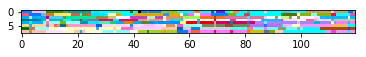

In [37]:
viz.imshow_rand(ws_larger[:, 15, :])

in the below cell, change 'raw_tiny' to 'prob_tiny', derived from ilastik probability maps. 

In [38]:
g_train = agglo.Rag(ws_tiny, raw_tiny, feature_manager=fc)
g_train_larger = agglo.Rag(ws_larger, raw_larger, feature_manager=fc)

In [43]:
(X, y, w, merges) = g_train.learn_agglomerate(gt_tiny, fc, classifier='logistic')[0]
y = y[:, 0]

In [56]:
(X2, y2, w2, merges2) = g_train_larger.learn_agglomerate(gt_larger, fc, classifier='logistic')[0]
y2 = y2[:, 0]

In [ ]:
rf_log = classify.get_classifier('logistic').fit(X,y)

In [57]:
rf_log_large = classify.get_classifier('logistic').fit(X2,y2)

In [ ]:
learned_policy = agglo.classifier_probability(fc, rf_log)

In [58]:
learned_policy_large = agglo.classifier_probability(fc, rf_log_large)

In [ ]:
g_test = agglo.Rag(ws_testing, raw_testing, feature_manager=fc, merge_priority_function=learned_policy)

In [79]:
g_test_large = agglo.Rag(ws_larger_testing, raw_larger_testing, feature_manager=fc, merge_priority_function=learned_policy_large)

In [75]:
g_test_large.agglomerate(np.inf)

100%|██████████| 499/499 [00:00<00:00, 1371.17it/s]


In [ ]:
seg_stack = [g_test.get_segmentation(t) for t in np.arange(0, 1, 0.05)]

In [80]:
seg_stack_large = [g_test_large.get_segmentation(t) for t in np.arange(0,1, 0.01)]

  0%|          | 0/5 [00:00<?, ?it/s]


In [ ]:
split_vi_score = [ev.split_vi(segs_stack[t], gt_testing) for t in range(len(segs_stack))]

In [78]:
seg_stack_large[0].shape

(5, 30, 30)

In [81]:
split_vi_score_large = [ev.split_vi(seg_stack_large[t], gt_larger_testing) for t in range(len(seg_stack_large))]

In [70]:
raw_larger.shape

(8, 120, 120)

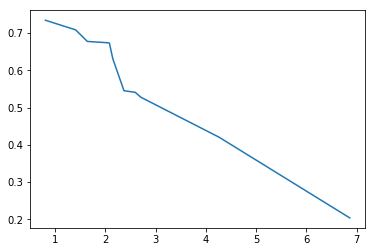

In [47]:
split_vi_array = np.array(split_vi_score)
fig, ax = plt.subplots()
ax.plot(split_vi_array[:, 1], split_vi_array[:, 0], label="number of seed points")

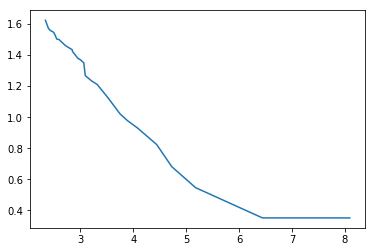

In [82]:
split_vi_array = np.array(split_vi_score_large)
fig, ax = plt.subplots()
ax.plot(split_vi_array[:, 1], split_vi_array[:, 0], label="number of seed points")

In [48]:
cont_small = ev.contingency_table(ws_tiny, gt_tiny)

In [46]:
gt_tiny_slice = gt[0, 0:30, 0:30]
raw_tiny_slice= raw[0, 0:30, 0:30]
ws_seeds_slice2 = regular_seeds(raw_tiny_slice.shape, n_points=400)
ws_tiny_slice2 = morpho.watershed(raw_tiny_slice, ws_seeds_slice2)

In [47]:
cont2 = ev.contingency_table(ws_tiny_slice2, gt_tiny_slice)

In [38]:
ev.split_vi(cont2)

array([ 0.25930817,  6.13413242])

In [85]:
from skimage import io
io.imsave(fname="raw_slice_1.tiff", arr=raw)

In [48]:
ws_tiny_stack = {}
count = 0
for i in range(100, 700, 50):
    ws_seeds_slice = regular_seeds(raw_tiny_slice.shape, n_points=i)
    ws_tiny_stack[count] = morpho.watershed(raw_tiny_slice, ws_seeds_slice)
    count+=1
    

In [49]:
np.all(ws_tiny_stack[0] ==ws_tiny_stack[6])

False

In [50]:
split = []
for i in range(len(ws_tiny_stack)):
    cont_a = ev.contingency_table(ws_tiny_stack[i], gt_tiny_slice)
    split.append(ev.split_vi(cont_a))

In [51]:
[(a, b) for a,b in split]

[(0.41352014169715101, 4.4776530516834017),
 (0.23143008035565901, 6.3472760791069227),
 (0.23143008035565901, 6.3472760791069227),
 (0.25930816510141425, 6.1341324156132302),
 (0.25930816510141425, 6.1341324156132302),
 (0.25930816510141425, 6.1341324156132302),
 (0.25930816510141425, 6.1341324156132302),
 (0.0, 8.9218944858203759),
 (0.0, 8.9218944858203759),
 (0.0, 8.9218944858203759),
 (0.0, 8.9218944858203759),
 (0.0, 8.9218944858203759)]

In [52]:
plt.plot([(a, b) for a,b in split])
plt.xlabel("merges")
plt.ylabel("splits")

In [53]:
from operator import itemgetter
a,b = map(itemgetter(0),split), map(itemgetter(1),split)

In [54]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['legend.fontsize'] = 10
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(split[0], split[1], number_points, label="number of seed points")
ax.legend()
plt.xlabel("merges")
plt.ylabel("splits")
plt.show()

NameError: name 'number_points' is not defined

In [41]:
import holoviews as hv

In [47]:
a = hv.Scatter3D(raw_small)

In [3]:
split = np.array(split)
split.shape

NameError: name 'split' is not defined

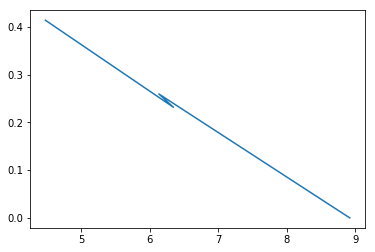

In [46]:
fig, ax = plt.subplots()
ax.plot(split[:, 1], split[:, 0], label="number of seed points")

NameError: name 'split' is not defined

100%|██████████| 8639/8639 [00:10<00:00, 823.78it/s] 
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it

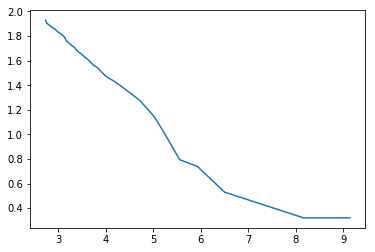

In [29]:
from gala import evaluate as ev, imio, viz, morpho, agglo, classify, features 
from skimage.util import regular_seeds
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
raw, gt = imio.read_cremi("Cremi_Data/sample_B_20160501.hdf", datasets=['volumes/raw', 'volumes/labels/neuron_ids'])
gt_larger_2 = gt[0:15, 0:120, 0:120]
raw_larger_2 = raw[0:15, 0:120, 0:120]
ws_larger_seeds_2 = regular_seeds(raw_larger_2[0].shape, n_points=700)
ws_larger_seeds_2 = np.broadcast_to(ws_larger_seeds_2, raw_larger_2.shape)
ws_larger_water = morpho.watershed_sequence(raw_larger_2, ws_larger_seeds_2, n_jobs=-1)
raw_larger_testing_2 = raw[0:15, 125:245, 125:245]
gt_larger_testing_2 = gt[0:15, 125:245, 125:245]
ws_larger_testing_2 = morpho.watershed_sequence(raw_larger_testing_2, ws_larger_seeds_2, n_jobs=-1)
fm = features.moments.Manager()
fh = features.histogram.Manager()
fc = features.base.Composite(children=[fm, fh])
g_train_larger_2 = agglo.Rag(ws_larger_water, raw_larger_2, feature_manager=fc)
(X2, y2, w2, merges2) = g_train_larger_2.learn_agglomerate(gt_larger_2, fc, classifier='logistic')[0]
y2 = y2[:, 0]
rf_log_large_2 = classify.get_classifier('logistic').fit(X2,y2)
learned_policy_large_2 = agglo.classifier_probability(fc, rf_log_large_2)
g_test_large_2 = agglo.Rag(ws_larger_testing_2, raw_larger_testing_2, feature_manager=fc, merge_priority_function=learned_policy_large_2)
g_test_large_2.agglomerate(np.inf)
seg_stack_large_2 = [g_test_large_2.get_segmentation(t) for t in np.arange(0,1, 0.01)]
split_vi_score_large_2 = [ev.split_vi(seg_stack_large_2[t], gt_larger_testing_2) for t in range(len(seg_stack_large_2))]
split_vi_array_2 = np.array(split_vi_score_large_2)
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
ax[0].plot(split_vi_array_2[:, 1], split_vi_array_2[:, 0])
cont_a = [ev.contingency_table(seg_stack_large_2[index], gt_larger_2) for index,_ in enumerate(seg_stack_large_2)]
cont_stack = [ev.split_vi(cont_a[i]) for i,_ in enumerate(cont_a)]
split_vi_array_new = np.array(cont_stack)
ax[1].plot(split_vi_array_new[:, 1], split_vi_array_new[:, 0])
ax[0].set_title("Split-VI without CT")
ax[1].set_title("Split-VI using CT")

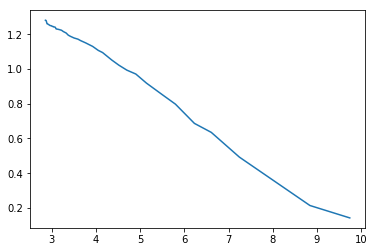

In [49]:
cont_a = [ev.contingency_table(seg_stack_large_2[index], gt_larger_2) for index,_ in enumerate(seg_stack_large_2)]
cont_stack = [ev.split_vi(cont_a[i]) for i,_ in enumerate(cont_a)]
split_vi_array_new = np.array(cont_stack)
fig, ax = plt.subplots()
ax.plot(split_vi_array_new[:, 1], split_vi_array_new[:, 0])

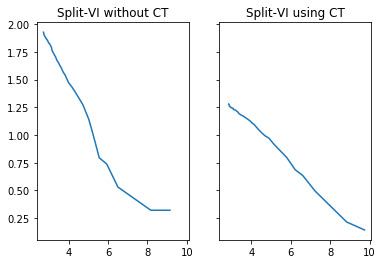

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
ax[0].plot(split_vi_array_2[:, 1], split_vi_array_2[:, 0])
ax[1].plot(split_vi_array_new[:, 1], split_vi_array_new[:, 0])
ax[0].set_title("Split-VI without CT")
ax[1].set_title("Split-VI using CT")

In [81]:
from skimage import io
io.imsave(fname="raw_larger_2.tiff", arr=raw_larger_2)
gg = np.argsort(np.bincount(gt_larger_2.astype(int).ravel()))[-10:]
sparse_large = imio.extract_segments(raw_larger_2, ids = gg)
imio.write_vtk(gt_larger_2,fn ="raw_cropped_newest.vtk", spacing=[4, 4, 40])
imio.write_vtk(sparse_large,fn ="sparse_gt_newest.vtk", spacing=[4, 4, 40])

In [76]:
gg

array([ 646,  618, 1958, 1771, 1909, 1876, 1880, 1929, 1874, 1883])